In [1]:
!pip install ..

Processing /Users/sarahrandall/Python-outbreak-info
  Preparing metadata (setup.py) ... done
  Created wheel for python-outbreak-info: filename=python_outbreak_info-1.0.4-py3-none-any.whl size=16181 sha256=7d7a379d1e82ad1ea9d993990b38223e4a5428b4dc3674936ff244e79881d2e5
  Stored in directory: /Users/sarahrandall/Library/Caches/pip/wheels/6f/2b/e7/3ed0c40d63901a9ba71e11202a6320922e8c98a9d9afcfcad4
Successfully built python-outbreak-info
  Attempting uninstall: python-outbreak-info
    Found existing installation: python-outbreak-info 1.0.4
    Uninstalling python-outbreak-info-1.0.4:
      Successfully uninstalled python-outbreak-info-1.0.4


In [1]:
from outbreak_data.authenticate_user import set_authentication
from outbreak_data import outbreak_data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

#### authenticate

In [3]:
from outbreak_data.authenticate_user import set_authentication
import auth_token
set_authentication(auth_token.get_auth_token())

#### pull ww data

In [69]:
state = "Ohio"
state_id = 'USA_US-OH'
startdate, enddate = "2023-09-01", "2024-01-01"
ww_samples = outbreak_data.get_wastewater_samples(region=state, date_range=[startdate, enddate])
ww_samples = outbreak_data.get_wastewater_lineages(ww_samples)

https://dev.outbreak.info/wastewater_metadata/query?fetch_all=true&q=geo_loc_region:Ohio AND collection_date:[2023-09-01 TO 2024-01-01] AND demix_success:true
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABa0fxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABa0fxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1


In [70]:
ww_samples['collection_date'] = pd.to_datetime(ww_samples['collection_date'])

In [71]:
ww_samples = outbreak_data.normalize_viral_loads_by_site(ww_samples)
ww_abundances = outbreak_data.datebin_and_agg(ww_samples, startdate=startdate, enddate=enddate, freq='7D')
#Gathers indiv records into weekly bunches and related lineages into bunches
#Plot each bunch individually

#### pull clinical data

In [72]:
clinical_samples = outbreak_data.all_lineage_prevalences(location=state_id, other_threshold=0.0, nday_threshold=1, server='api.outbreak.info')

https://api.outbreak.info/genomics/prevalence-by-location-all-lineages?location_id=USA_US-OH&ndays=180&nday_threshold=1&other_threshold=0.0


In [73]:
clinical_samples['date'] = pd.to_datetime(clinical_samples['date'])

In [74]:
clinical_samples = clinical_samples.rename(columns={'date': 'collection_date', 'lineage': 'name', 'prevalence': 'abundance'})
clinical_samples['normed_viral_load'] = 1
clinical_samples['ww_population'] = 1
clinical_samples['name'] = clinical_samples['name'].str.upper()
clinical_abundances = outbreak_data.datebin_and_agg(clinical_samples, startdate=startdate, enddate=enddate, freq='7D', loaded=False)

#### get the lineage tree

In [75]:
tree, lineage_key = outbreak_data.get_tree()

#### cluster lineages on average abundances

In [76]:
ww_abundance_data = ww_abundances.drop(columns=['viral_load']).mul(ww_abundances['viral_load'], axis=0).sum()
clinical_abundance_data = clinical_abundances.drop(columns=['viral_load', 'OTHER']).sum()
combined_abundances = (ww_abundance_data/ww_abundance_data.sum()).add(clinical_abundance_data/clinical_abundance_data.sum(), fill_value=0)
clusters = outbreak_data.cluster_lineages((tree, lineage_key), combined_abundances, n=16, alpha=0.1)

#### wastewater plots

In [77]:
def get_colors(lins, isnatural, lineage_key):
    colors = np.searchsorted(
        sorted([lin['alias'] for lin in lineage_key.values()]),
        [lineage_key[lin]['alias'] for lin in lins] )
    colors = colors ** 2
    colors = (colors - np.min(colors)) / (np.max(colors)-np.min(colors)) * 0.75
    return hsv_to_rgb([(color, 1, 0.333 + 0.333*b) for color, b in zip(colors, isnatural)])

def get_riverplot_baseline(clustered_abundances, n=128):
    c = clustered_abundances.drop(columns=['viral_load']) \
         .mul(clustered_abundances['viral_load'].interpolate(), axis=0).dropna()
    d = c.div(clustered_abundances['viral_load'].dropna(), axis=0)
    def score(O):
        return (c.cumsum(axis=1).add(O, axis=0).rolling(window=2).apply(np.diff).mul(d)**2).sum().sum()
    Ot = -clustered_abundances['viral_load'].dropna()/2
    for n in range(128):
        O = np.random.normal(size=Ot.shape) / (n+48) * 2
        if score(O+Ot) < score(Ot):
            Ot += O
            Ot -= np.mean(Ot)
    return pd.Series(Ot, c.index).reindex(clustered_abundances.index).interpolate()

Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

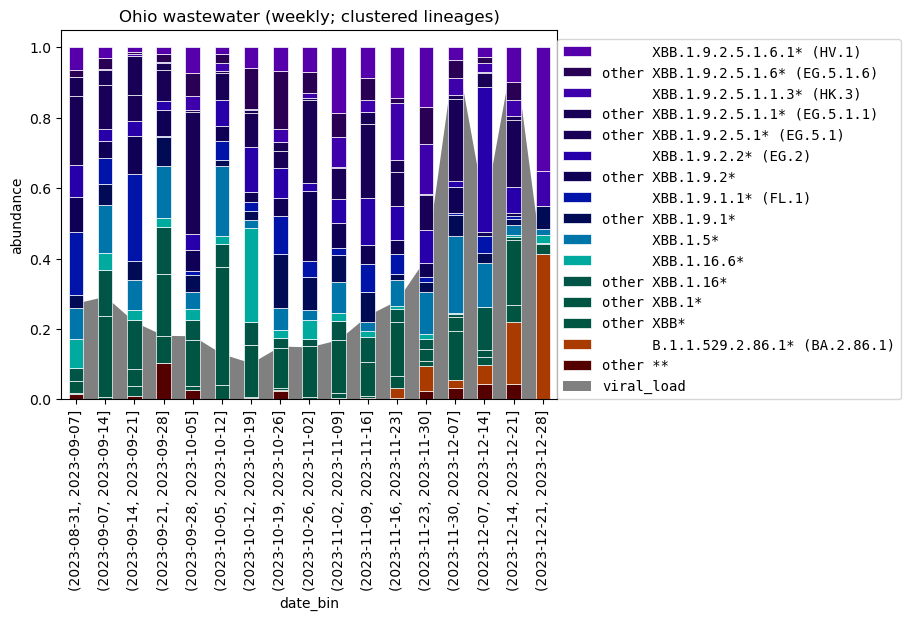

In [78]:
clustered_ww_abundances, root_lineages, isnatural = outbreak_data.cluster_df((tree, lineage_key), clusters, ww_abundances)
#takes abundance data for all lineages and puts the min groups - columns

clustered_ww_abundances['viral_load'].interpolate().plot(kind='area', color='gray', linewidth=0)
colors = get_colors(root_lineages, isnatural, lineage_key)
clustered_ww_abundances.drop(columns=['viral_load']).plot(
    kind = 'bar', stacked = True, edgecolor = 'w', linewidth = .5, color = colors, ax=plt.gca() )
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} wastewater (weekly; clustered lineages)')




In [79]:
clustered_ww_abundances

,other **,B.1.1.529.2.86.1* (BA.2.86.1),other XBB*,other XBB.1*,other XBB.1.16*,XBB.1.16.6*,XBB.1.5*,other XBB.1.9.1*,XBB.1.9.1.1* (FL.1),other XBB.1.9.2*,XBB.1.9.2.2* (EG.2),other XBB.1.9.2.5.1* (EG.5.1),other XBB.1.9.2.5.1.1* (EG.5.1.1),XBB.1.9.2.5.1.1.3* (HK.3),other XBB.1.9.2.5.1.6* (EG.5.1.6),XBB.1.9.2.5.1.6.1* (HV.1),viral_load
date_bin,,,,,,,,,,,,,,,,,
"(2023-08-31, 2023-09-07]",1.409030e-02,0.000000,0.003292,0.035760,0.037073,0.079873,0.089823,0.035420,0.180506,0.098883,0.089711,0.197244,0.054967,0.000003,0.019975,0.063379,0.273546
"(2023-09-07, 2023-09-14]",1.122368e-03,0.000000,0.004991,0.231691,0.130640,0.047636,0.136336,0.060071,0.071839,0.048282,0.035225,0.123759,0.044441,0.002419,0.031980,0.029568,0.292918
"(2023-09-14, 2023-09-21]",9.775007e-03,0.000000,0.028518,0.047474,0.140349,0.027830,0.084630,0.055502,0.245547,0.107882,0.041998,0.074116,0.112347,0.005378,0.006590,0.012064,0.220087
"(2023-09-21, 2023-09-28]",1.023302e-01,0.000020,0.078553,0.176440,0.131741,0.024935,0.149164,0.083031,0.002910,0.072966,0.026443,0.088193,0.019854,0.000646,0.023632,0.019141,0.181897
"(2023-09-28, 2023-10-05]",2.631897e-02,0.000030,0.010326,0.132535,0.056157,0.031921,0.046410,0.050382,0.011353,0.058761,0.046077,0.346306,0.005520,0.038958,0.067379,0.071566,0.180556
"(2023-10-05, 2023-10-12]",1.471852e-03,0.000086,0.040199,0.332857,0.067482,0.021841,0.197525,0.018767,0.053408,0.043613,0.073759,0.076221,0.005207,0.024054,0.025896,0.017614,0.129579
"(2023-10-12, 2023-10-19]",2.387247e-03,0.000033,0.003360,0.149620,0.064147,0.267934,0.022597,0.026174,0.025116,0.028020,0.126788,0.096062,0.009856,0.004029,0.114655,0.059222,0.103367
"(2023-10-19, 2023-10-26]",2.447062e-02,0.001021,0.006304,0.114448,0.027301,0.024792,0.059800,0.154493,0.109376,0.049775,0.084089,0.049795,0.026772,0.034987,0.166091,0.066486,0.151496
"(2023-10-26, 2023-11-02]",3.733879e-04,0.001674,0.005677,0.144714,0.020339,0.052555,0.028411,0.093277,0.045184,0.199435,0.023309,0.234850,0.005586,0.014832,0.058340,0.071445,0.148942


Text(0.5, 1.0, 'Ohio wastewater (weekly; clustered lineages)')

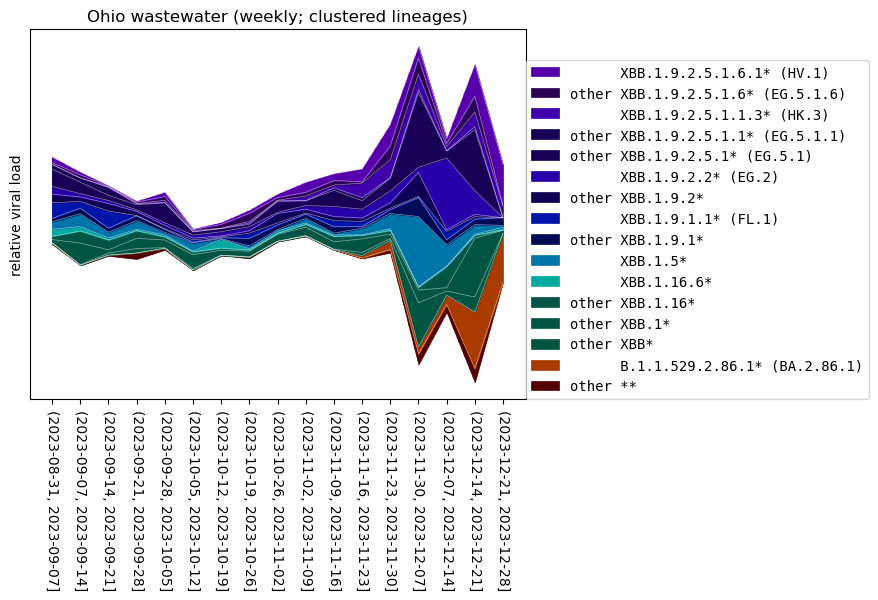

In [80]:
last_line = get_riverplot_baseline(clustered_ww_abundances)
for lin, color in zip(clustered_ww_abundances.drop(columns=['viral_load']).columns, colors):
    next_line = last_line + clustered_ww_abundances[lin] * clustered_ww_abundances['viral_load'].interpolate()
    plt.fill_between( clustered_ww_abundances[lin].index.astype(str), last_line.interpolate(), next_line.interpolate(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot(clustered_ww_abundances[lin].index.astype(str), next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( clustered_ww_abundances[lin].index.astype(str), last_line, next_line,
                      color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} wastewater (weekly; clustered lineages)')

In [ ]:
#### wastewater plots

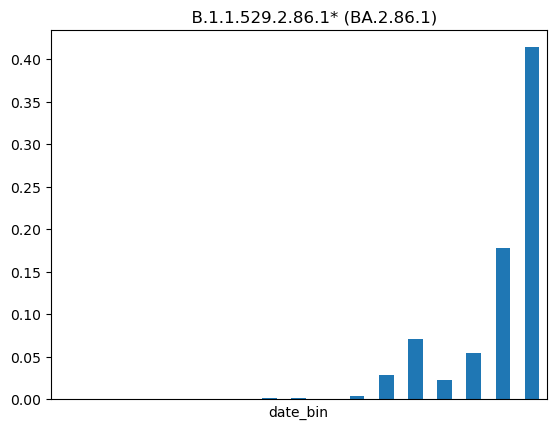

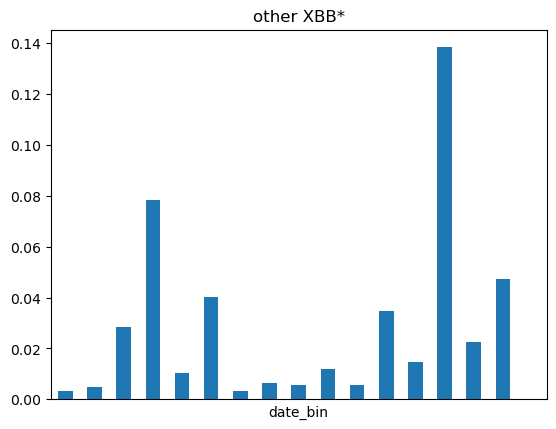

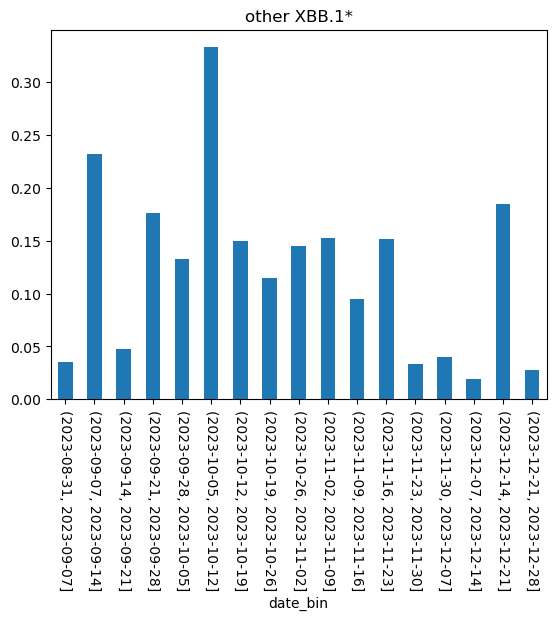

In [162]:
for i, column in enumerate(clustered_ww_abundances.columns[1:4]):   
    clustered_ww_abundances[column].plot(rot = -90, kind = "bar")
    plt.title(column)
    if i != len(clustered_ww_abundances.columns[1:4]) - 1:
         plt.xticks([])
    plt.savefig(f'{column}.png', bbox_inches="tight")
    plt.show()

    
#look at first three columns - change shape
# pick three to show

# do the same with clinical data copy code
# commit to sprint
    
    

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

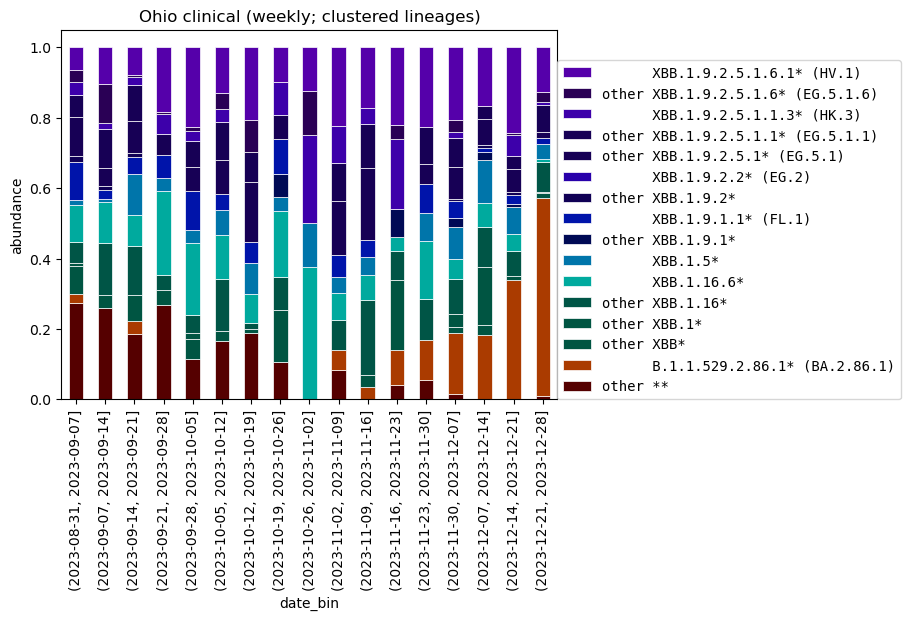

In [155]:
clustered_cl_abundances, root_lineages, isnatural = outbreak_data.cluster_df((tree, lineage_key), clusters, clinical_abundances)
clustered_cl_abundances['viral_load'] = ww_abundances['viral_load'].reindex(clustered_cl_abundances.index)
colors = get_colors(root_lineages, isnatural, lineage_key)
clustered_cl_abundances.drop(columns=['viral_load']).plot(
    kind = 'bar', stacked = True, edgecolor = 'w', linewidth = .5, color = colors, ax=plt.gca() )
plt.ylabel('abundance')
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.title(f'{state} clinical (weekly; clustered lineages)')

Text(0.5, 1.0, 'Ohio clinical (weekly; clustered lineages)')

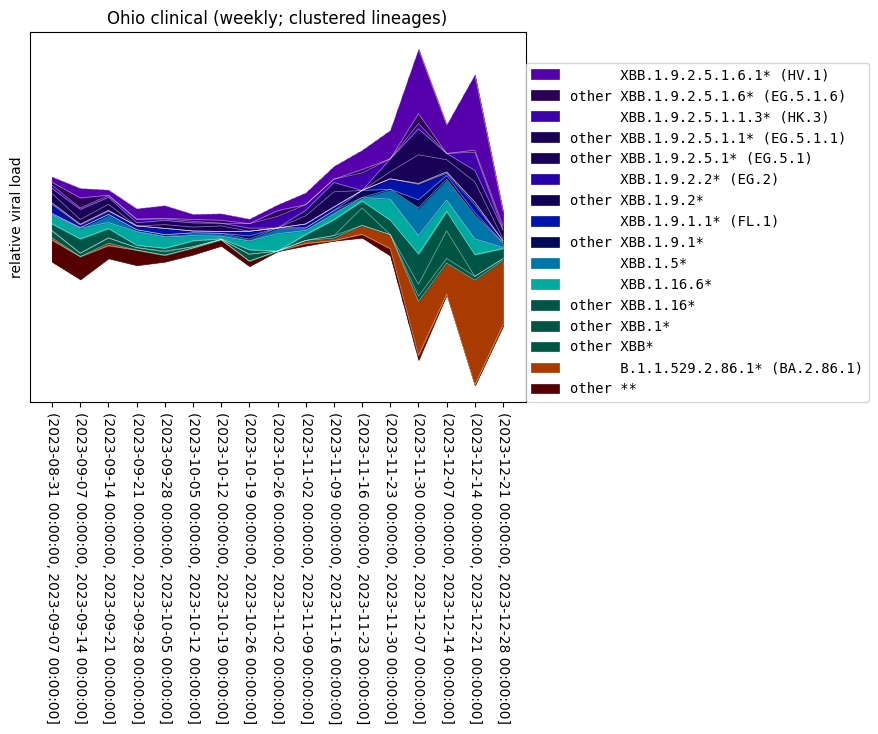

In [14]:
last_line = get_riverplot_baseline(clustered_cl_abundances)
for lin, color in zip(clustered_cl_abundances.drop(columns=['viral_load']).columns, colors):
    next_line = last_line + clustered_cl_abundances[lin] * clustered_cl_abundances['viral_load'].interpolate()
    plt.fill_between( clustered_cl_abundances[lin].index.astype(str), last_line.interpolate(), next_line.interpolate(),
                      color=list(color)+[0.25], edgecolor=color, linewidth=0, hatch='|||' )
    plt.plot(clustered_cl_abundances[lin].index.astype(str), next_line.interpolate(), color='white', linewidth=0.5, alpha=0.5)
    plt.fill_between( clustered_cl_abundances[lin].index.astype(str), last_line, next_line,
                      color=list(color), edgecolor=color, linewidth=0.5, label=lin )
    last_line = next_line
plt.legend(loc=(1,0), prop={"family":"monospace"}, reverse=True)
plt.xticks(rotation=-90)
plt.ylabel('relative viral load')
plt.yticks([])
plt.title(f'{state} clinical (weekly; clustered lineages)')

#### clinical plots

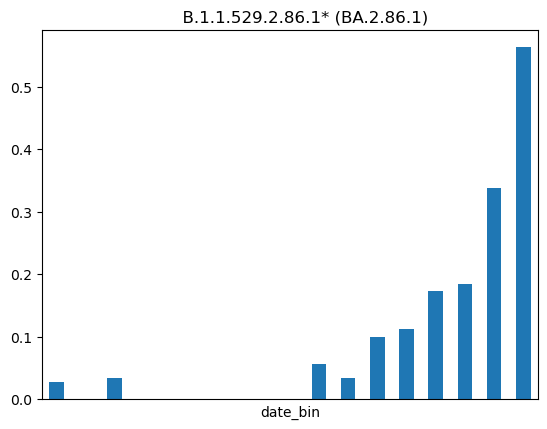

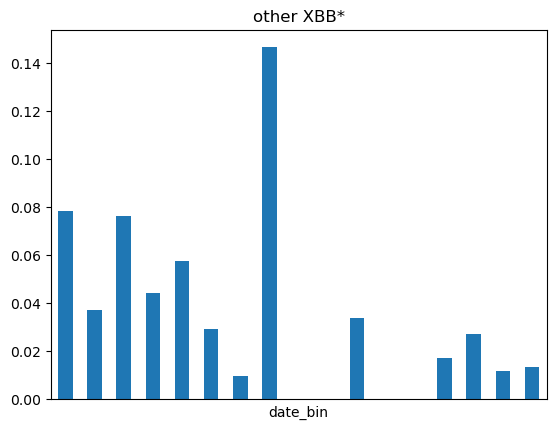

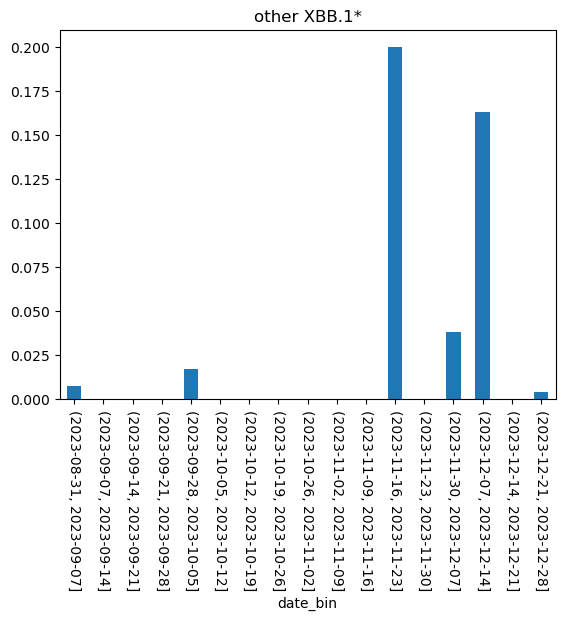

In [161]:
for i, column in enumerate(clustered_cl_abundances.columns[1:4]):   
    clustered_cl_abundances[column].plot(rot = -90, kind = "bar")
    plt.title(column)
    if i != len(clustered_cl_abundances.columns[1:4]) - 1:
         plt.xticks([])
    plt.savefig(f'{column}.png', bbox_inches="tight")
    plt.show()